# **NB 5.3: Sentiment Analysis Over time - After BERT Topic Modeling**

In [1]:
# Standard Inputs

import sklearn
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load
from joblib import Parallel, delayed

In [2]:
# Multiprocessing

#pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True )

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
# Imports the Google Cloud client library

from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [4]:
#Visuals

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

## Importing data files

In [5]:
%%time

### Loading positive (v3) and negative expanded (v4) sentiment datasets
df_filt_pos=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v3_POS_BERTopics_Sentiments_NER.csv',lineterminator='\n')
df_filt_neg=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v4_NEG_BERTopics_Sentiments_NER.csv',lineterminator='\n')

CPU times: user 42.6 s, sys: 5 s, total: 47.6 s
Wall time: 2min 17s


In [6]:
%%time

### Loading an older data file with all articles
df4_samp=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_filtered.parquet')


CPU times: user 51.6 s, sys: 18.2 s, total: 1min 9s
Wall time: 1min 1s


In [7]:
articles_period=df4_samp.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
articles_period.rename(columns={'url':'count_total_articles'}, inplace=True)
articles_period[0:5]

,year_pub,month,month-year,count_total_articles
0,2020,1,Jan 2020,2886
1,2020,2,Feb 2020,2745
2,2020,3,Mar 2020,3083
3,2020,4,Apr 2020,2961
4,2020,5,May 2020,2910


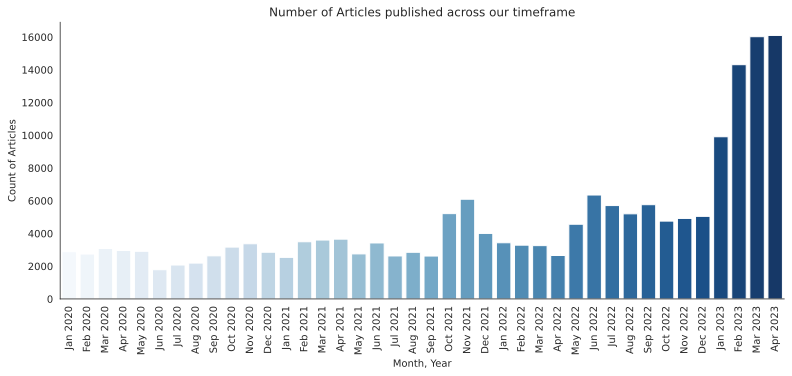

In [33]:
fig,axes=plt.subplots(figsize=(13, 5))
# RdBu_palette = sns.color_palette('RdBu', n_colors=len(articles_period['month-year'].unique()))
green_palette = sns.color_palette('Blues', n_colors=len(articles_period['month-year'].unique()))


sns.barplot(x=articles_period['month-year'],y=articles_period['count_total_articles'], ax=axes, palette = green_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month, Year')
plt.ylabel('Count of Articles')
plt.title('Number of Articles published across our timeframe')

sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/all_articles.png')

In [8]:
pos_articles_period=df_filt_pos.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_articles_period.rename(columns={'url':'count_pos_articles'}, inplace=True)
pos_articles_period[0:5]

,year_pub,month,month-year,count_pos_articles
0,2020,1,Jan 2020,876
1,2020,2,Feb 2020,748
2,2020,3,Mar 2020,936
3,2020,4,Apr 2020,869
4,2020,5,May 2020,764


In [9]:
neg_articles_period=df_filt_neg.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
neg_articles_period.rename(columns={'url':'count_neg_articles'}, inplace=True)
neg_articles_period[0:5]

,year_pub,month,month-year,count_neg_articles
0,2020,1,Jan 2020,128
1,2020,2,Feb 2020,113
2,2020,3,Mar 2020,96
3,2020,4,Apr 2020,64
4,2020,5,May 2020,84


In [10]:
articles_sents=articles_period.merge(pos_articles_period['count_pos_articles'], left_on=articles_period['month-year'], right_on=pos_articles_period['month-year'], how='left')
articles_sents.drop(['key_0'], axis=1, inplace=True)
articles_sents=articles_sents.merge(neg_articles_period['count_neg_articles'], on=articles_sents['month-year'], how='left')
articles_sents.drop(['key_0'], axis=1, inplace=True)

articles_sents['prop_pos_articles']=np.round((articles_sents['count_pos_articles']/articles_sents['count_total_articles'])*100,2)
articles_sents['prop_neg_articles']=np.round((articles_sents['count_neg_articles']/articles_sents['count_total_articles'])*100,2)

# articles_sents
# articles_sents.merge(neg_articles_period['count_neg_articles'], on=articles_sents['month-year'], how='left')

In [41]:
articles_sents.to_csv('articles_sents.csv')

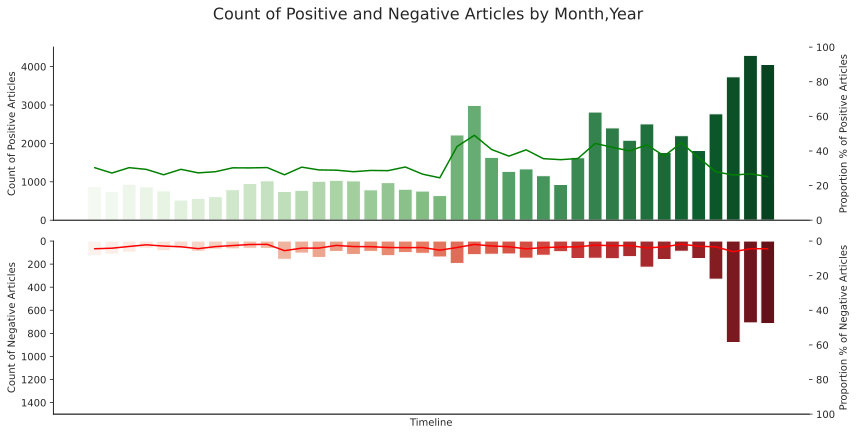

In [22]:
fig,axes=plt.subplots(2,1,figsize=(12, 6), sharex=True)
axes=axes.flatten()

green_palette = sns.color_palette('Greens', n_colors=len(articles_sents['month-year'].unique()))
red_palette = sns.color_palette('Reds', n_colors=len(articles_sents['month-year'].unique()))

#axes[0]
sns.barplot(x=articles_sents['month-year'],y=articles_sents['count_pos_articles'], ax=axes[0], palette=green_palette)
axes[0].tick_params(axis='x', labelbottom=False)

#axes[0] twin
ax01=axes[0].twinx()
sns.lineplot(x=articles_sents['month-year'],y=articles_sents['prop_pos_articles'], ax=ax01, color = 'green')
ax01.set_ylabel('Proportion % of Positive Articles')
ax01.set_ylim(0, 100)  # Set y-axis limits for the lower subplot
ax01.tick_params(axis='x', labelbottom=False)


#axes[1]
sns.barplot(x=articles_sents['month-year'],y=articles_sents['count_neg_articles'], ax=axes[1], palette=red_palette)
axes[1].set_ylim(0, 1500)  # Set y-axis limits for the lower subplot
axes[1].tick_params(axis='x', labelbottom=False)


#axes[1] twin
ax11=axes[1].twinx()
sns.lineplot(x=articles_sents['month-year'],y=articles_sents['prop_neg_articles'], ax=ax11, color = 'red')
ax11.set_ylabel('Proportion % of Negative Articles')
ax11.tick_params(axis='x', labelbottom=False)
ax11.set_ylim(0, 100)  # Set y-axis limits for the lower subplot

sns.despine()

axes[0].set_ylabel('Count of Positive Articles')
axes[0].set_xlabel('')  # Remove x-axis label from the upper subplot

axes[1].set_ylabel('Count of Negative Articles')
axes[1].set_xlabel('Timeline')

# axes[1].set_title('Negative Articles Count by Month-Year')
axes[1].invert_yaxis()
ax11.invert_yaxis()


# plt.xticks(rotation=90)
fig.suptitle('Count of Positive and Negative Articles by Month,Year', fontsize=16, y=1)

# Show the plot
plt.tight_layout()
plt.show()

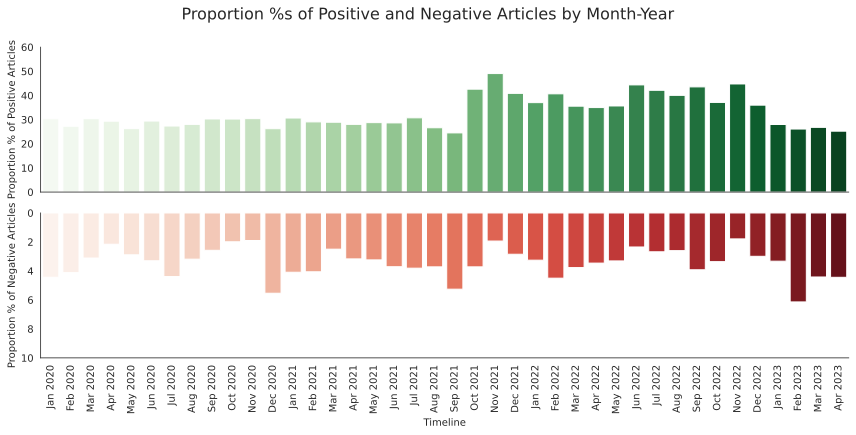

In [14]:
fig,axes=plt.subplots(2,1,figsize=(12, 6), sharex=True)
axes=axes.flatten()

green_palette = sns.color_palette('Greens', n_colors=len(articles_sents['month-year'].unique()))
red_palette = sns.color_palette('Reds', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=articles_sents['month-year'],y=articles_sents['prop_pos_articles'], ax=axes[0], palette=green_palette)
sns.barplot(x=articles_sents['month-year'],y=articles_sents['prop_neg_articles'], ax=axes[1], palette=red_palette)
sns.despine()

plt.xticks(rotation=90)

axes[0].set_ylabel('Proportion % of Positive Articles')
axes[0].set_xlabel('')  # Remove x-axis label from the upper subplot
axes[0].set_ylim(0, 60)  # Set y-axis limits for the upper subplot

# axes[0].set_title('Postitive Articles Count by Month-Year')
# axes[0].set_xlabel('Count of Positive Articles')


axes[1].set_ylabel('Proportion % of Negative Articles')
axes[1].set_xlabel('Timeline')
axes[1].set_ylim(0, 10)  # Set y-axis limits for the lower subplot

# axes[1].set_title('Negative Articles Count by Month-Year')
axes[1].invert_yaxis()

fig.suptitle('Proportion %s of Positive and Negative Articles by Month-Year', fontsize=16, y=1)


# Show the plot
plt.tight_layout()
plt.show()

----
### Checking for Positive and Negative Topics as obtained from BERT

In [23]:
pd.options.display.max_colwidth=500
df_filt_pos[['Bert_topics','Bert_topics_words']]

,Bert_topics,Bert_topics_words
0,-1,"[('ai', 0.011616725684365191), ('data', 0.008184820620037109), ('new', 0.007532065440961323), ('technology', 0.007088503198156179), ('media', 0.006741932060619692), ('news', 0.006555062414371287), ('market', 0.0065322453300298115), ('gray', 0.006268907474194732), ('business', 0.006194498186140644), ('group', 0.006136437718931887)]"
1,0,"[('market', 0.016054439728526534), ('ai', 0.01180140497948441), ('intelligence', 0.009147460510216643), ('global', 0.009123790305122805), ('artificial', 0.008492948021819309), ('data', 0.00846226823252483), ('report', 0.008449734583495305), ('growth', 0.008311238686154689), ('analysis', 0.008179651443282462), ('industry', 0.007254009101229231)]"
2,4,"[('defense', 0.017968931768814877), ('aviation', 0.01740172995230673), ('military', 0.015987205024604052), ('aircraft', 0.015395219718556638), ('air', 0.015342252206827478), ('intelligence', 0.012445896904445806), ('artificial', 0.011382008787376732), ('news', 0.011009593661747492), ('market', 0.010282248495033269), ('shield', 0.010155675411358889)]"
3,-1,"[('ai', 0.011616725684365191), ('data', 0.008184820620037109), ('new', 0.007532065440961323), ('technology', 0.007088503198156179), ('media', 0.006741932060619692), ('news', 0.006555062414371287), ('market', 0.0065322453300298115), ('gray', 0.006268907474194732), ('business', 0.006194498186140644), ('group', 0.006136437718931887)]"
4,2,"[('healthcare', 0.02551418708646057), ('market', 0.020083308869425023), ('medical', 0.015322549930893794), ('intelligence', 0.015064299088974213), ('artificial', 0.015008045308885885), ('drug', 0.013568132820278253), ('health', 0.012816501443306861), ('cancer', 0.01176434000533691), ('ai', 0.010370307612129984), ('patients', 0.010326105365587444)]"
...,...,...
60876,-1,"[('ai', 0.011616725684365191), ('data', 0.008184820620037109), ('new', 0.007532065440961323), ('technology', 0.007088503198156179), ('media', 0.006741932060619692), ('news', 0.006555062414371287), ('market', 0.0065322453300298115), ('gray', 0.006268907474194732), ('business', 0.006194498186140644), ('group', 0.006136437718931887)]"
60877,0,"[('market', 0.016054439728526534), ('ai', 0.01180140497948441), ('intelligence', 0.009147460510216643), ('global', 0.009123790305122805), ('artificial', 0.008492948021819309), ('data', 0.00846226823252483), ('report', 0.008449734583495305), ('growth', 0.008311238686154689), ('analysis', 0.008179651443282462), ('industry', 0.007254009101229231)]"
60878,-1,"[('ai', 0.011616725684365191), ('data', 0.008184820620037109), ('new', 0.007532065440961323), ('technology', 0.007088503198156179), ('media', 0.006741932060619692), ('news', 0.006555062414371287), ('market', 0.0065322453300298115), ('gray', 0.006268907474194732), ('business', 0.006194498186140644), ('group', 0.006136437718931887)]"
60879,0,"[('market', 0.016054439728526534), ('ai', 0.01180140497948441), ('intelligence', 0.009147460510216643), ('global', 0.009123790305122805), ('artificial', 0.008492948021819309), ('data', 0.00846226823252483), ('report', 0.008449734583495305), ('growth', 0.008311238686154689), ('analysis', 0.008179651443282462), ('industry', 0.007254009101229231)]"


In [24]:
# Topic 4 - Conversational AI
df_filt_pos_convai=df_filt_pos[df_filt_pos.Bert_topics==1]
# df_filt_pos_convai.sample(2)

In [25]:
pos_convai_period=df_filt_pos_convai.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_convai_period.rename(columns={'url':'count_articles'}, inplace=True)

In [26]:
pos_convai_period

,year_pub,month,month-year,count_articles
0,2020,1,Jan 2020,17
1,2020,2,Feb 2020,13
2,2020,3,Mar 2020,16
3,2020,4,Apr 2020,26
4,2020,5,May 2020,28
5,2020,6,Jun 2020,16
6,2020,7,Jul 2020,14
7,2020,8,Aug 2020,9
8,2020,9,Sep 2020,22
9,2020,10,Oct 2020,11


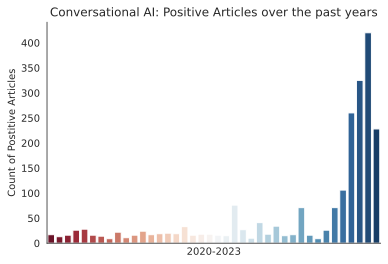

In [42]:
fig,axes=plt.subplots(figsize=(6, 4))
RdBu_palette = sns.color_palette('RdBu', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=pos_convai_period['month-year'],y=pos_convai_period['count_articles'], ax=axes, palette = RdBu_palette)
axes.tick_params(axis='x', labelbottom=False)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('2020-2023')
plt.ylabel('Count of Postitive Articles')
plt.title('Conversational AI: Positive Articles over the past years')


sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/convai_pos.png')

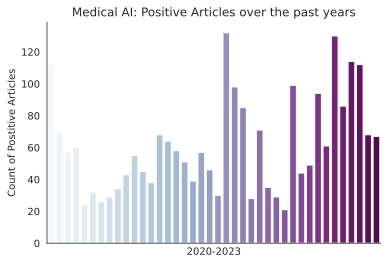

In [44]:
#Healthcare

df_filt_pos_medai=df_filt_pos[df_filt_pos.Bert_topics.isin([2,20,24])]
pos_medai_period=df_filt_pos_medai.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_medai_period.rename(columns={'url':'count_articles'}, inplace=True)

bupu_palette = sns.color_palette('BuPu', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(6, 4))
sns.barplot(x=pos_medai_period['month-year'],y=pos_medai_period['count_articles'], ax=axes, palette=bupu_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('2020-2023')
plt.ylabel('Count of Postitive Articles')
plt.title('Medical AI: Positive Articles over the past years')
axes.tick_params(axis='x', labelbottom=False)

sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/medai_pos.png')

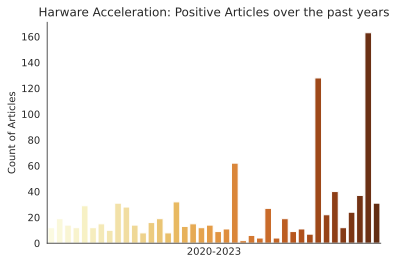

In [45]:
# Processing Hardware

df_filt_pos_gpu=df_filt_pos[df_filt_pos.Bert_topics.isin([6])]
pos_gpu_period=df_filt_pos_gpu.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_gpu_period.rename(columns={'url':'count_articles'}, inplace=True)

YlOrBr_palette = sns.color_palette('YlOrBr', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(6, 4))
sns.barplot(x=pos_gpu_period['month-year'],y=pos_gpu_period['count_articles'], ax=axes, palette=YlOrBr_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('2020-2023')
plt.ylabel('Count of Articles')
plt.title('Harware Acceleration: Positive Articles over the past years')
axes.tick_params(axis='x', labelbottom=False)
sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/gpu_pos.png')

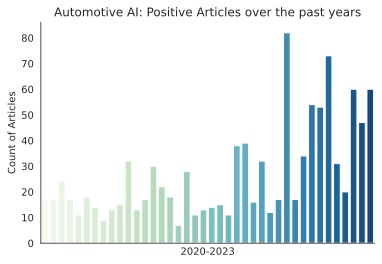

In [47]:
# Automotive Sector

df_filt_pos_auto=df_filt_pos[df_filt_pos.Bert_topics.isin([5])]
pos_auto_period=df_filt_pos_auto.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_auto_period.rename(columns={'url':'count_articles'}, inplace=True)

GnBu_palette = sns.color_palette('GnBu', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(6, 4))
sns.barplot(x=pos_auto_period['month-year'],y=pos_auto_period['count_articles'], ax=axes, palette=GnBu_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('2020-2023')
plt.ylabel('Count of Articles')
plt.title('Automotive AI: Positive Articles over the past years')
axes.tick_params(axis='x', labelbottom=False)

sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/autoai_pos.png')

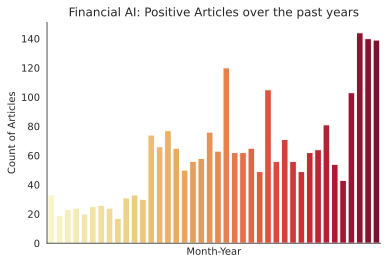

In [48]:
# Financial Sector

df_filt_pos_fin=df_filt_pos[df_filt_pos.Bert_topics.isin([3,11])]
pos_fin_period=df_filt_pos_fin.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_fin_period.rename(columns={'url':'count_articles'}, inplace=True)

YlOrRd_palette = sns.color_palette('YlOrRd', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(6, 4))
sns.barplot(x=pos_fin_period['month-year'],y=pos_fin_period['count_articles'], ax=axes, palette=YlOrRd_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Articles')
plt.title('Financial AI: Positive Articles over the past years')
axes.tick_params(axis='x', labelbottom=False)

sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/finai_pos.png')

In [32]:
import pandas as pd

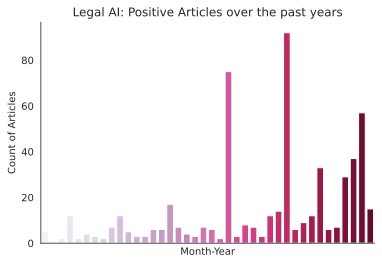

In [50]:
# Financial Sector

df_filt_pos_mus=df_filt_pos[df_filt_pos.Bert_topics.isin([13])]
pos_mus_period=df_filt_pos_mus.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_mus_period.rename(columns={'url':'count_articles'}, inplace=True)

PuRd_palette = sns.color_palette('PuRd', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(6, 4))
sns.barplot(x=pos_mus_period['month-year'],y=pos_mus_period['count_articles'], ax=axes, palette=PuRd_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Articles')
plt.title('Legal AI: Positive Articles over the past years')
axes.tick_params(axis='x', labelbottom=False)

sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/finai_pos.png')